In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_loglikelihood, log_logprior_global_uniform, \
    log_probability, plot_corner_emcee, plot_walker_emcee, display_median_from_chain, \
    log_likelihood, log_prior_global_uniform, log_logprobability, log_logprior_global_uniform_simoul, \
    log_loglikelihood_simoul, log_logprobability_simoul, plot_fit_with_MCMCsamples
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
#Load data from chain 

samples_total = np.load("../data/MCMC/logsamples_total.npy")
samplesflat_total = np.load("../data/MCMC/logsamplesflat_total.npy")

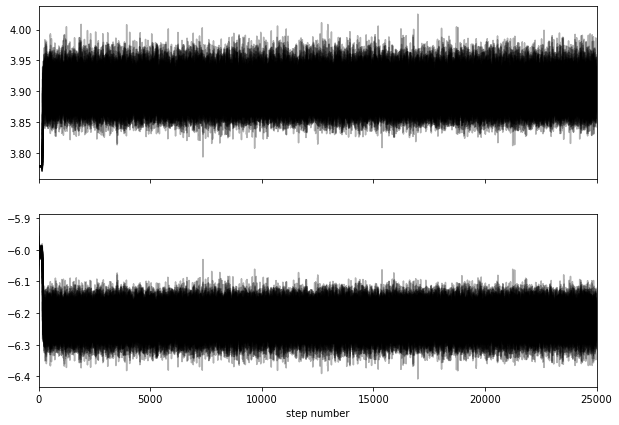

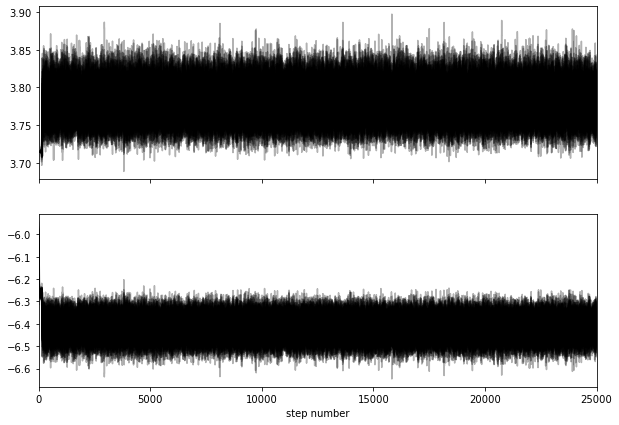

In [5]:
%matplotlib inline
plot_walker_emcee(samples_total)

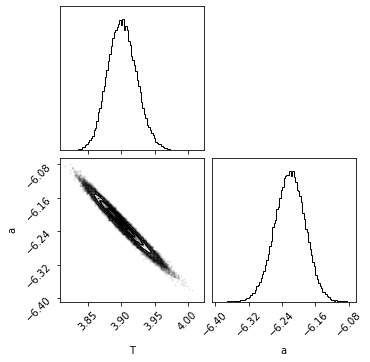

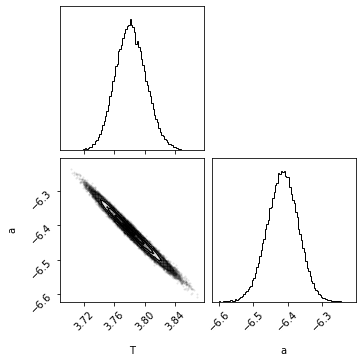

In [6]:
plot_corner_emcee(samplesflat_total)

In [3]:
#show median from chains in log rep
results = display_median_from_chain(samplesflat_total) ##implement mode, mean, log!!

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
#median, 80, 16 quantile
T_med = 10**results[0][0]
a_med = 10**results[2][0]

T_high = 10**(results[0][0] + results[1][0][1])
T_low = 10**(results[0][0] - results[1][0][0])
a_high = 10**(results[2][0] + results[3][0][0])
a_low = 10**(results[2][0] - results[3][0][0])


In [5]:
#median, 80, 16 quantile
T_med2 = 10**results[0][1]
a_med2 = 10**results[2][1]

T_high2 = 10**(results[0][1] + results[1][1][1])
T_low2 = 10**(results[0][1] - results[1][1][0])
a_high2 = 10**(results[2][1] + results[3][1][0])
a_low2 = 10**(results[2][1] - results[3][1][0])

In [14]:
np.round(T_med,-1),  np.round(T_high - T_med,-1), np.round(T_med - T_low,-1)

(7950.0, 420.0, 380.0)

In [8]:
T_med2,  T_high2 - T_med2, T_med2 - T_low2 

(6040.005112512493, 297.5245143206039, 270.14229685398186)

In [12]:
T_med = [T_med, T_med2]
a_med = [a_med, a_med2]

In [13]:

trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
flare1 = np.genfromtxt("../results/values/brightnesstot_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [14]:
brightness_flares = brightness_flares* u.erg *u.s**(-1) * u.cm**(-2)
brightnesserror_flares = brightnesserror_flares * u.erg *u.s**(-1) * u.cm**(-2)
brightness_flares = brightness_flares.to("W/m^2")
brightnesserror_flares = brightnesserror_flares.to("W/m^2")

brightness_flares = brightness_flares.to("W/m^2").value
brightnesserror_flares = brightnesserror_flares.to("W/m^2").value 

flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [15]:
#sum of datapoints in wavelength array for continous model
limitss = np.asarray([limit[0][1] - limit[0][0], limit[1][1] - limit[1][0] , limit[2][1] - limit[2][0], \
                      limit[3][1] - limit[3][0]]) 

In [16]:
#TRAPPIST-1
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

<IPython.core.display.Javascript object>


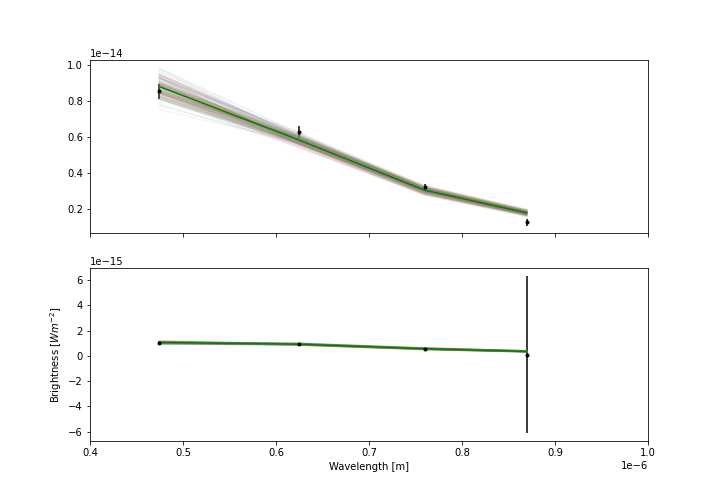

In [17]:
%matplotlib notebook 
plot_fit_with_MCMCsamples(samplesflat_total, brightness_flares, brightnesserror_flares, T_med,a_med, \
                          t_star, r_star, dist_star, flux_SED, wavelength_M2, wavelength_SED, limit, limitss, continous=False )

# -------------------------------------------------------------------------

In [28]:
import corner
import matplotlib.lines as mlines
def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

params_p50s=[[3.900547739211139, -6.22151422689929],[3.7810373062262683,  -6.415350291397084]] #Truth parameters


CORNER_KWARGS = dict(
    smooth=0.9,
    # label_kwargs=dict(fontsize=11),
    #title_kwargs=dict(fontsize=12),
    quantiles=[0.16, 0.5,0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), #1-sig & 2-sig
     #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    #max_n_ticks=3,
)


def overlaid_corner(samples_list, sample_labels, sample_colors,param_labels,params_p50s=params_p50s):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    # cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = sample_colors#[cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        truths=[*params_p50s[0]],
        labels=param_labels,
        truth_color=colors[0], bins = 100,
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            truths=[*params_p50s[idx]],
            truth_color=colors[idx], bins = 100,
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    #print('corner_pRT'+perfix+'_final.pdf')
    #plt.savefig('corner_pRT'+perfix+'_final.pdf',bbox_inches=0.)
    #plt.close()

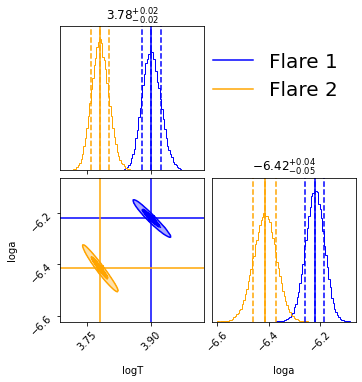

In [29]:

overlaid_corner(samplesflat_total,["Flare 1", "Flare 2"],["Blue", "Orange"], ["logT", "loga"])